# Imports and method


In [3]:
from carbontracker import parser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics
import os
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
#import Models as M
!pip3 install patchify
import patchify as Pf
from PIL import Image
from sklearn.metrics import precision_recall_curve
from datetime import datetime
from torchvision import models
import os
!pip install carbontracker


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
os.chdir(os.getcwd())

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics


def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,3)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        self.ax.legend
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def set_xlabel(self, label, labelpad=None):
        self.ax.set_xlabel(label, labelpad=labelpad)


In [6]:
# Open the log file for reading
def process_log_files(log_files):
    time_values = []
    energy_values = []
    co2eq_values = []
    for log_file_path in log_files:
        # Open the log file for reading
        with open(log_file_path, 'r') as file:
            read_values = False
            for line in file:
                if 'Actual consumption' in line:
                    read_values = True
                elif read_values and line.strip() != '':
                    parts = line.strip().split('\t')
                    if len(parts) == 2:
                        label = parts[0].strip()
                        value = parts[1].strip()
                        if label == 'Time:':
                            hours, minutes, seconds = value.split(':')
                            total_min = int(int(hours) * 3600 + int(minutes) * 60 + int(seconds))/60
                            time_values.append(total_min)
                        elif label == 'Energy:':
                            energy = float(value.rstrip(' kWh'))
                            energy_values.append(energy)
                        #elif label == 'CO2eq:':
                        #    co2eq = float(value.rstrip(' g'))
                        #    co2eq_values.append(co2eq)
                elif 'CarbonTracker: Finished monitoring.' in line:
                    break
    return time_values, energy_values

In [11]:
def plot_radar(labels, acc_values, time_values, energy_values, total_energy, somelabel = 'RadarConv'):
    variables = (r'     $P_v$', r'$E(kWh)$', r'DM $E(kWh)$           ', r'$T(m)$')
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, [(0, 0.8), (0, 0.003), (0,0.32), (0, 1)])
    for i in range(len(time_values)):
        data = (acc_values[i], energy_values[i], total_energy[i], time_values[i])
        radar.plot(data, label=labels[i])
        radar.fill(data, alpha=0.2)

    le = radar.ax.legend(loc='upper right', frameon=1, bbox_to_anchor=(1.3, 1.1))
    frame = le.get_frame()
    frame.set_facecolor('grey')
    frame.set_edgecolor('black')

    plt.title('Distribution Matching Consumption Comparison', y=1.1)
    plt.savefig(f'{somelabel}.png', bbox_inches = 'tight', dpi = 256)
    plt.show()

In [12]:
os.chdir(os.getcwd())
path = 'Data/Loss_Alzheimer_MRI/test/CarbonLogs/'
end = '.log'

In [13]:
from functools import reduce
def Average(lst):
    return reduce(lambda a, b: a + b, lst) / len(lst)

# ConvNet DM

In [19]:
#CONVNET
Convnet_4 = [f'{path}NEW_DMAfterAL_LR1_k20_100_even_4_1ConvNet_3812_2023-05-12T230302Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_4_2ConvNet_11524_2023-05-12T230857Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_4ConvNet_1736_2023-05-12T230444Z_carbontracker_output{end}'
                  ] 

#CONVNET
Convnet_40 = [f'{path}NEW_DMAfterAL_LR1_k20_100_even_40_1ConvNet_11520_2023-05-12T233441Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_40_2ConvNet_20844_2023-05-12T233623Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_40ConvNet_21756_2023-05-12T233321Z_carbontracker_output{end}'
                  ] 

Convnet_402 = [f'{path}NEW_DMAfterAL_LR1_k20_100_even_402_1ConvNet_3836_2023-05-12T233927Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_402_2ConvNet_22500_2023-05-12T234834Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_402ConvNet_21496_2023-05-12T233811Z_carbontracker_output{end}'
                  ] 


time_values_conv4, energy_values_conv4 = process_log_files(Convnet_4)
time_values_conv40, energy_values_conv40 = process_log_files(Convnet_40)
time_values_conv402, energy_values_conv402 = process_log_files(Convnet_402)

time_con4 = Average(time_values_conv4)
energy_con4 = Average(energy_values_conv4)
time_con40 = Average(time_values_conv40)
energy_con40 = Average(energy_values_conv40)
time_con402 = Average(time_values_conv402)
energy_con402 = Average(energy_values_conv402)


#FINAL
time_conv = [time_con4, time_con40, time_con402]
energy_conv = [energy_con4, energy_con40 ,energy_con402]

Time values: [0.5888888888888889, 0.47222222222222227, 0.8166666666666668]
Energy values: [0.0014963333333333332, 0.001246, 0.0022626666666666667]


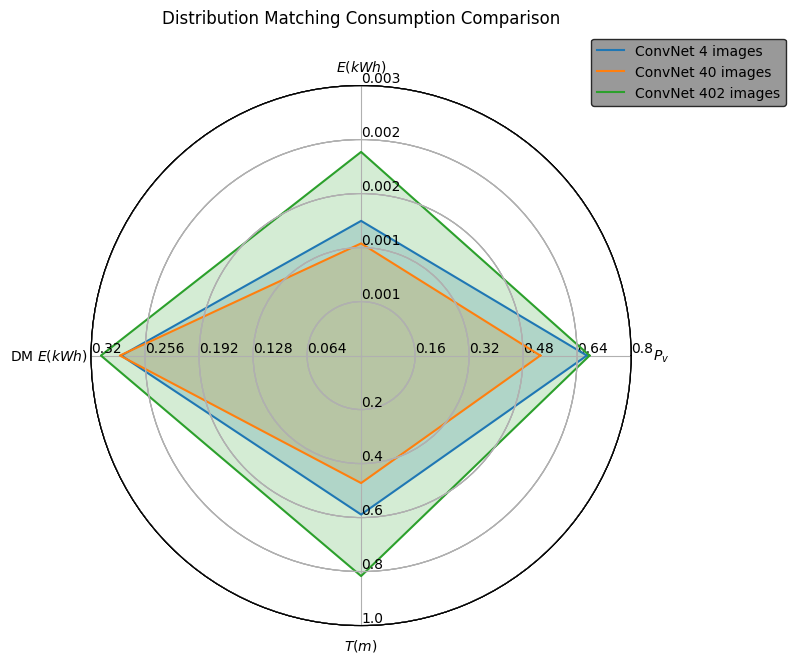

In [20]:

acc_values_conv= [0.669, 0.531, 0.677]
# dm energy for generating 
DM_energy = [0.284152, 0.285919, 0.308364]


# Print the extracted values
print("Time values:", time_conv)
print("Energy values:", energy_conv)

labels = ['ConvNet 4 images', 'ConvNet 40 images', 'ConvNet 402 images']
plot_radar(labels, acc_values_conv, time_conv, energy_conv, DM_energy) #somelabel = something

# DenseNet DM

In [21]:
Densenet_4 = [f'{path}NEW_DMAfterAL_LR1_k20_100_even_4_1_densDenseNet2_9176_2023-05-14T111538Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_4_2_densDenseNet2_7220_2023-05-14T133547Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_4_densDenseNet_2408_2023-05-14T000637Z_carbontracker_output{end}'
                  ] 

Densenet_40 = [f'{path}NEW_DMAfterAL_LR1_k20_100_even_40_1_densDenseNet2_24876_2023-05-14T113415Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_40_2_densDenseNet2_23968_2023-05-14T135556Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_40_densDenseNet2_22660_2023-05-14T003458Z_carbontracker_output{end}'
                  ] 

Densenet_402 = [f'{path}NEW_DMAfterAL_LR1_k20_100_even_402_1_densDenseNet2_15372_2023-05-14T130659Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_402_2_densDenseNet2_16924_2023-05-14T151050Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_402_densDenseNet2_24972_2023-05-14T104829Z_carbontracker_output{end}'
                  ] 


time_values_dens4, energy_values_dens4 = process_log_files(Densenet_4)
time_values_dens40, energy_values_dens40 = process_log_files(Densenet_40)
time_values_dens402, energy_values_dens402 = process_log_files(Densenet_402)

time_den4 = Average(time_values_dens4)
energy_den4 = Average(energy_values_dens4)
time_den40 = Average(time_values_dens40)
energy_den40 = Average(energy_values_dens40)
time_den402 = Average(time_values_dens402)
energy_den402 = Average(energy_values_dens402)


#FINAL
time_dens = [time_den4, time_den40, time_den402]
energy_dens = [energy_den4, energy_den40 ,energy_den402]

In [22]:
def plot_radar2(labels, acc_values, time_values, energy_values, total_energy, somelabel = 'RadarDens'):
    variables = (r'     $P_v$', r'$E(kWh)$', r'DM $E(kWh)$           ', r'$T(m)$')
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, [(0, 0.8), (0, 0.15), (0,0.32), (0, 50)])
    for i in range(len(time_values)):
        data = (acc_values[i], energy_values[i], total_energy[i], time_values[i])
        radar.plot(data, label=labels[i])
        radar.fill(data, alpha=0.2)

    le = radar.ax.legend(loc='upper right', frameon=1, bbox_to_anchor=(1.3, 1.1))
    frame = le.get_frame()
    frame.set_facecolor('grey')
    frame.set_edgecolor('black')

    plt.title('Distribution Matching Consumption Comparison', y=1.1)
    plt.savefig(f'{somelabel}.png', bbox_inches = 'tight', dpi = 256)
    plt.show()

Time values: [17.433333333333334, 49.06666666666666, 25.705555555555552]
Energy values: [0.052843, 0.14923266666666668, 0.07494633333333334]


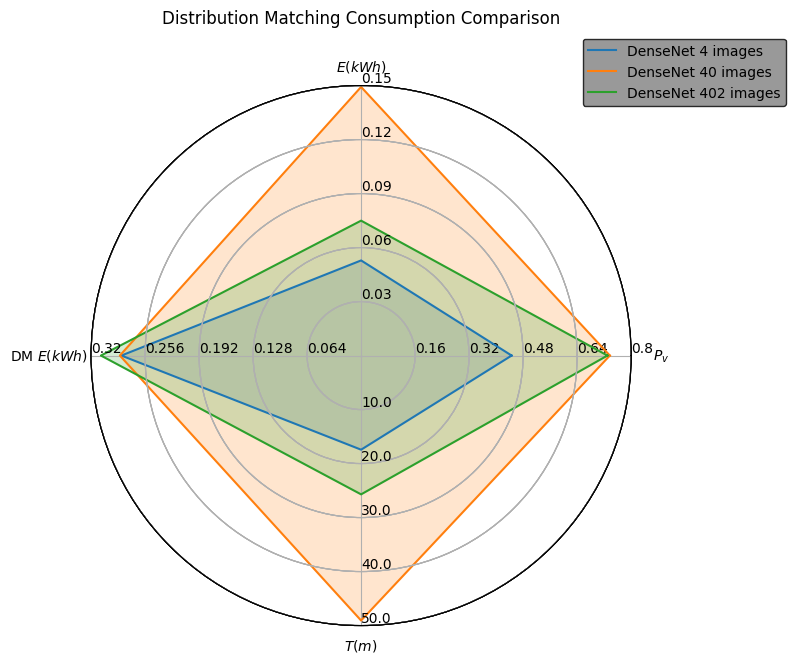

In [23]:
#[ResNet, DensNet, ConvNet]
acc_values_den= [0.446, 0.737, 0.73]
# dm energy for generating 
DM_energy = [0.284152, 0.285919, 0.308364]


# Print the extracted values
print("Time values:", time_dens)
print("Energy values:", energy_dens)

labels = ['DenseNet 4 images', 'DenseNet 40 images', 'DenseNet 402 images']
plot_radar2(labels, acc_values_den, time_dens, energy_dens, DM_energy) #somelabel = something

# ResNet DM

In [24]:
#CONVNET
Resnet_4 = [f'{path}NEW_DMAfterAL_LR1_k20_100_even_4_1_resResNet2_13504_2023-05-13T152651Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_4_2_resResNet2_6752_2023-05-13T152842Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_4_resResNet2_14876_2023-05-13T152343Z_carbontracker_output{end}'
                  ] 

#CONVNET
Resnet_40 = [f'{path}NEW_DMAfterAL_LR1_k20_100_even_40_1_resResNet2_7028_2023-05-13T144928Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_40_2_resResNet2_10712_2023-05-13T151850Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_40_2_resResNet2_10712_2023-05-13T151850Z_carbontracker_output{end}'
                  ] 

Resnet_402 = [f'{path}NEW_DMAfterAL_LR1_k20_100_even_402_1_resResNet2_17944_2023-05-13T143128Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_402_2_resResNet2_11088_2023-05-13T143707Z_carbontracker_output{end}'
                  ,f'{path}NEW_DMAfterAL_LR1_k20_100_even_402_resResNet2_15864_2023-05-13T142413Z_carbontracker_output{end}'
                  ] 


time_values_res4, energy_values_res4 = process_log_files(Resnet_4)
time_values_res40, energy_values_res40 = process_log_files(Resnet_40)
time_values_res402, energy_values_res402 = process_log_files(Resnet_402)

time_res4 = Average(time_values_res4)
energy_res4 = Average(energy_values_res4)
time_res40 = Average(time_values_res40)
energy_res40 = Average(energy_values_res40)
time_res402 = Average(time_values_res402)
energy_res402 = Average(energy_values_res402)


#FINAL
time_res = [time_res4, time_res40, time_res402]
energy_res = [energy_res4, energy_res40 ,energy_res402]

In [25]:
def plot_radar3(labels, acc_values, time_values, energy_values, total_energy, somelabel = 'RadarRes'):
    variables = (r'     $P_v$', r'$E(kWh)$', r'DM $E(kWh)$           ', r'$T(m)$')
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, [(0, 0.8), (0.0, 0.004), (0.0,0.32), (0, 3)])
    for i in range(len(time_values)):
        data = (acc_values[i], energy_values[i], total_energy[i], time_values[i])
        radar.plot(data, label=labels[i])
        radar.fill(data, alpha=0.2)

    le = radar.ax.legend(loc='upper right', frameon=1, bbox_to_anchor=(1.3, 1.1))
    frame = le.get_frame()
    frame.set_facecolor('grey')
    frame.set_edgecolor('black')

    plt.title('Distribution Matching Consumption Comparison', y=1.1)
    plt.savefig(f'{somelabel}.png', bbox_inches = 'tight', dpi = 256)
    plt.show()

Time values: [1.3277777777777777, 1.2833333333333334, 2.6722222222222225]
Energy values: [0.003760333333333334, 0.0035486666666666665, 0.0035073333333333332]


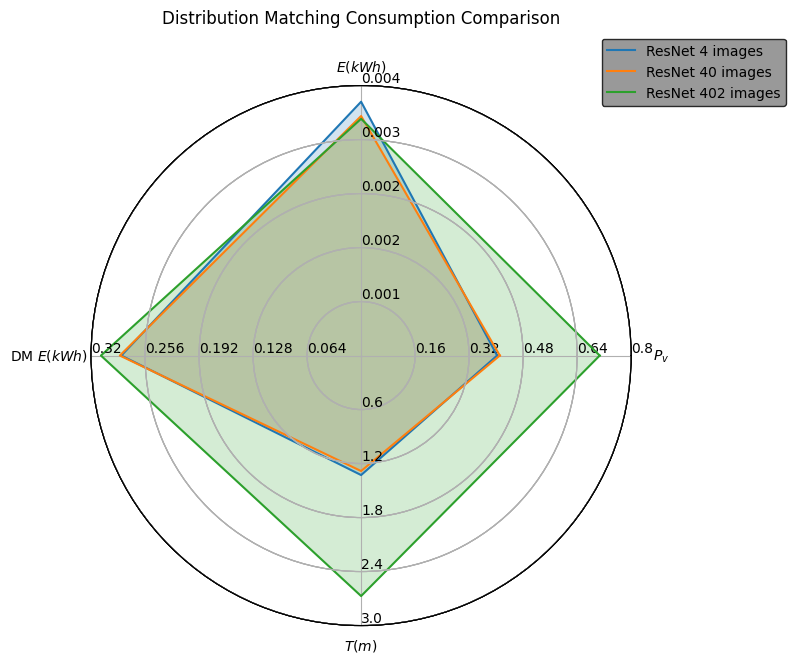

In [26]:
#[ResNet, DensNet, ConvNet]
acc_values_res= [0.403, 0.411, 0.707]
# dm energy for generating 
DM_energy = [0.284152, 0.285919, 0.308364]


# Print the extracted values
print("Time values:", time_res)
print("Energy values:", energy_res)

labels = ['ResNet 4 images', 'ResNet 40 images', 'ResNet 402 images']
plot_radar3(labels, acc_values_res, time_res, energy_res, DM_energy) #somelabel = something

# Gradient Matching

In [30]:
os.chdir(os.getcwd())
path = 'Data/Synthetic_Alzheimer_MRI/CarbonLogs/'
end = '.log'

## ConvNet

In [34]:
#CONVNET
GMConvnet_4 = [f'{path}GMAlzheimer_K1000_4_ours_run2ConvNet_21708_2023-05-15T223926Z_carbontracker_output{end}'
                  ,f'{path}GMAlzheimer_K1000_4_ours_run3ConvNet_6764_2023-05-21T145441Z_carbontracker_output{end}'
                  ,f'{path}GMAlzheimer_K1000_4_ours_run2ConvNet_22700_2023-05-15T223836Z_carbontracker_output{end}'
                  ] 

#CONVNET
GMConvnet_40 = [f'{path}GMAlzheimer_K1000_40_ours_run1ConvNet_14032_2023-05-14T172221Z_carbontracker_output{end}'
                  ,f'{path}GMAlzheimer_K1000_40_ours_run2ConvNet_4972_2023-05-15T201923Z_carbontracker_output{end}'
                  ,f'{path}GMAlzheimer_K1000_40_ours_run3ConvNet_5300_2023-05-15T204052Z_carbontracker_output{end}'
                  ] 

GMtime_values_conv4, GMenergy_values_conv4 = process_log_files(GMConvnet_4)
GMtime_values_conv40, GMenergy_values_conv40 = process_log_files(GMConvnet_40)

GMtime_con4 = Average(GMtime_values_conv4)
GMenergy_con4 = Average(GMenergy_values_conv4)
GMtime_con40 = Average(GMtime_values_conv40)
GMenergy_con40 = Average(GMenergy_values_conv40)

#FINAL
GMtime_conv = [GMtime_con4, GMtime_con40]
GMenergy_conv = [GMenergy_con4, GMenergy_con40]

In [80]:
def GMplot_radar1(labels, acc_values, time_values, energy_values, total_energy, somelabel = 'GMRadarConv'):
    variables = (r'     $P_v$', r'$E(kWh)$', r'GM $E(kWh)$           ', r'$T(m)$')
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, [(0, 0.8), (0, 0.003), (0,2.5), (0, 1)])
    for i in range(len(time_values)):
        data = (acc_values[i], energy_values[i], total_energy[i], time_values[i])
        radar.plot(data, label=labels[i])
        radar.fill(data, alpha=0.2)

    le = radar.ax.legend(loc='upper right', frameon=1, bbox_to_anchor=(1.3, 1.1))
    frame = le.get_frame()
    frame.set_facecolor('grey')
    frame.set_edgecolor('black')

    plt.title('Gradient Matching Consumption Comparison', y=1.1)
    plt.savefig(f'{somelabel}.png', bbox_inches = 'tight', dpi = 256)
    plt.show()

Time values: [0.41111111111111115, 0.4833333333333334]
Energy values: [0.0011003333333333334, 0.0012430000000000002]


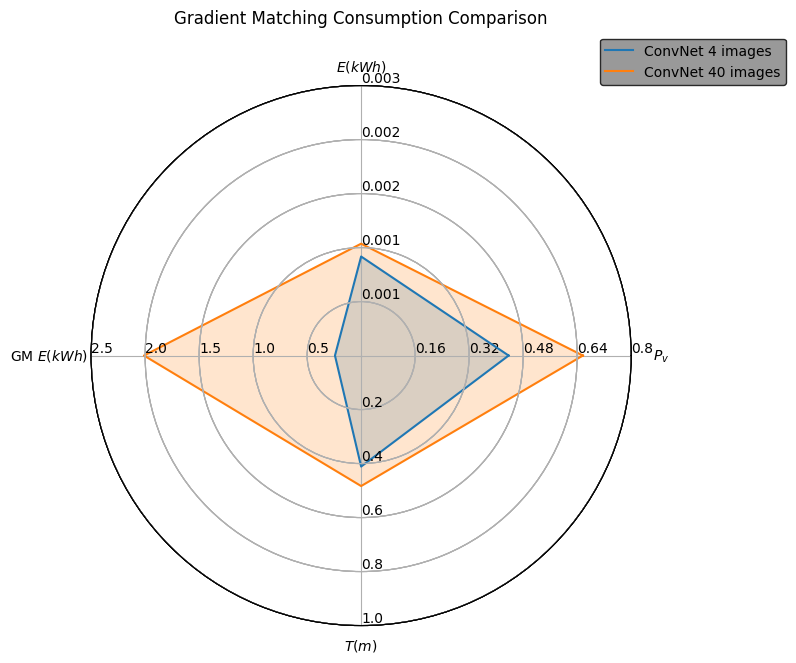

In [81]:
GMacc_values_conv= [0.437, 0.657]
# dm energy for generating 
GM_energy = [0.24228850000000002, 2.0108360000000003]


# Print the extracted values
print("Time values:", GMtime_conv)
print("Energy values:", GMenergy_conv)

GMlabels = ['ConvNet 4 images', 'ConvNet 40 images']
GMplot_radar1(GMlabels, GMacc_values_conv, GMtime_conv, GMenergy_conv, GM_energy) #somelabel = something

## DensNet


In [82]:
GMDensenet_4 = [f'{path}GMAlzheimer_K1000_4_ours_run1DenseNet_148_2023-05-21T142101Z_carbontracker_output{end}'
                  ,f'{path}GMAlzheimer_K1000_4_ours_run2DenseNet_3544_2023-05-21T143412Z_carbontracker_output{end}'
                  ,f'{path}GMAlzheimer_K1000_4_ours_run3DenseNet_5420_2023-05-21T144437Z_carbontracker_output{end}'
                  ] 

GMDensenet_40 = [f'{path}GMAlzheimer_K1000_40_ours_run1DenseNet_4400_2023-05-21T150004Z_carbontracker_output{end}'
                  ,f'{path}GMAlzheimer_K1000_40_ours_run2DenseNet_6748_2023-05-21T151622Z_carbontracker_output{end}'
                  ,f'{path}GMAlzheimer_K1000_40_ours_run3DenseNet_2588_2023-05-21T152930Z_carbontracker_output{end}'
                  ] 


GMtime_values_dens4, GMenergy_values_dens4 = process_log_files(GMDensenet_4)
GMtime_values_dens40, GMenergy_values_dens40 = process_log_files(GMDensenet_40)

GMtime_den4 = Average(GMtime_values_dens4)
GMenergy_den4 = Average(GMenergy_values_dens4)
GMtime_den40 = Average(GMtime_values_dens40)
GMenergy_den40 = Average(GMenergy_values_dens40)


#FINAL
GMtime_dens = [GMtime_den4, GMtime_den40]
GMenergy_dens = [GMenergy_den4, GMenergy_den40]

In [83]:
def GMplot_radar2(labels, acc_values, time_values, energy_values, total_energy, somelabel = 'GMRadarDens'):
    variables = (r'     $P_v$', r'$E(kWh)$', r'GM $E(kWh)$           ', r'$T(m)$')
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, [(0, 0.8), (0, 0.003), (0,2.5), (0, 1.5)])
    for i in range(len(time_values)):
        data = (acc_values[i], energy_values[i], total_energy[i], time_values[i])
        radar.plot(data, label=labels[i])
        radar.fill(data, alpha=0.2)

    le = radar.ax.legend(loc='upper right', frameon=1, bbox_to_anchor=(1.3, 1.1))
    frame = le.get_frame()
    frame.set_facecolor('grey')
    frame.set_edgecolor('black')

    plt.title('Gradient Matching Consumption Comparison', y=1.1)
    plt.savefig(f'{somelabel}.png', bbox_inches = 'tight', dpi = 256)
    plt.show()

Time values: [1.0222222222222221, 0.6888888888888888]
Energy values: [0.0029193333333333332, 0.001895]


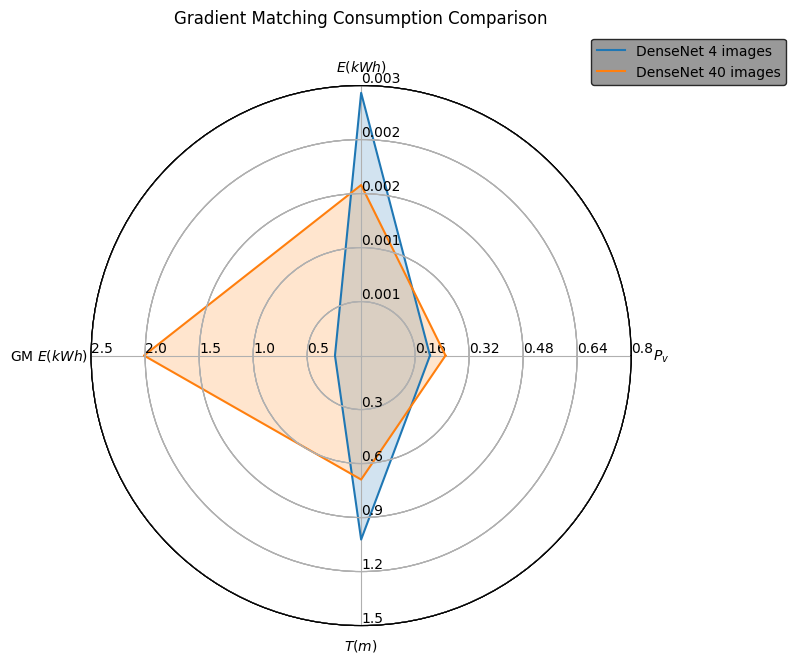

In [84]:
GMacc_values_den= [0.204, 0.25]
# GM energy for generating 
GM_energy = [0.24228850000000002, 2.0108360000000003]


# Print the extracted values
print("Time values:", GMtime_dens)
print("Energy values:", GMenergy_dens)

GMlabels = ['DenseNet 4 images', 'DenseNet 40 images']
GMplot_radar2(GMlabels, GMacc_values_den, GMtime_dens, GMenergy_dens, GM_energy) #somelabel = something

## ResNet

In [85]:
#CONVNET
GMResnet_4 = [f'{path}GMAlzheimer_K1000_4_ours_run1ResNet_4608_2023-05-21T141928Z_carbontracker_output{end}'
                  ,f'{path}GMAlzheimer_K1000_4_ours_run2ResNet_3096_2023-05-21T143827Z_carbontracker_output{end}'
                  ,f'{path}GMAlzheimer_K1000_4_ours_run3ResNet_20492_2023-05-21T144224Z_carbontracker_output{end}'
                  ] 

GMResnet_40 = [f'{path}GMAlzheimer_K1000_40_ours_run1ResNet_14176_2023-05-21T150815Z_carbontracker_output{end}'
                  ,f'{path}GMAlzheimer_K1000_40_ours_run2ResNet_5004_2023-05-21T151022Z_carbontracker_output{end}'
                  ,f'{path}GMAlzheimer_K1000_40_ours_run3ResNet_2248_2023-05-21T152610Z_carbontracker_output{end}'
                  ] 

GMtime_values_res4, GMenergy_values_res4 = process_log_files(GMResnet_4)
GMtime_values_res40, GMenergy_values_res40 = process_log_files(GMResnet_40)


GMtime_res4 = Average(GMtime_values_res4)
GMenergy_res4 = Average(GMenergy_values_res4)
GMtime_res40 = Average(GMtime_values_res40)
GMenergy_res40 = Average(GMenergy_values_res40)


#FINAL
GMtime_res = [GMtime_res4, GMtime_res40]
GMenergy_res = [GMenergy_res4, GMenergy_res40]

In [86]:
def GMplot_radar3(labels, acc_values, time_values, energy_values, total_energy, somelabel = 'GMRadarRes'):
    variables = (r'     $P_v$', r'$E(kWh)$', r'GM $E(kWh)$           ', r'$T(m)$')
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, [(0, 0.8), (0, 0.003), (0,2.5), (0, 1)])
    for i in range(len(time_values)):
        data = (acc_values[i], energy_values[i], total_energy[i], time_values[i])
        radar.plot(data, label=labels[i])
        radar.fill(data, alpha=0.2)

    le = radar.ax.legend(loc='upper right', frameon=1, bbox_to_anchor=(1.3, 1.1))
    frame = le.get_frame()
    frame.set_facecolor('grey')
    frame.set_edgecolor('black')

    plt.title('Gradient Matching Consumption Comparison', y=1.1)
    plt.savefig(f'{somelabel}.png', bbox_inches = 'tight', dpi = 256)
    plt.show()

Time values: [0.6722222222222222, 0.5666666666666667]
Energy values: [0.0021049999999999997, 0.0017533333333333333]


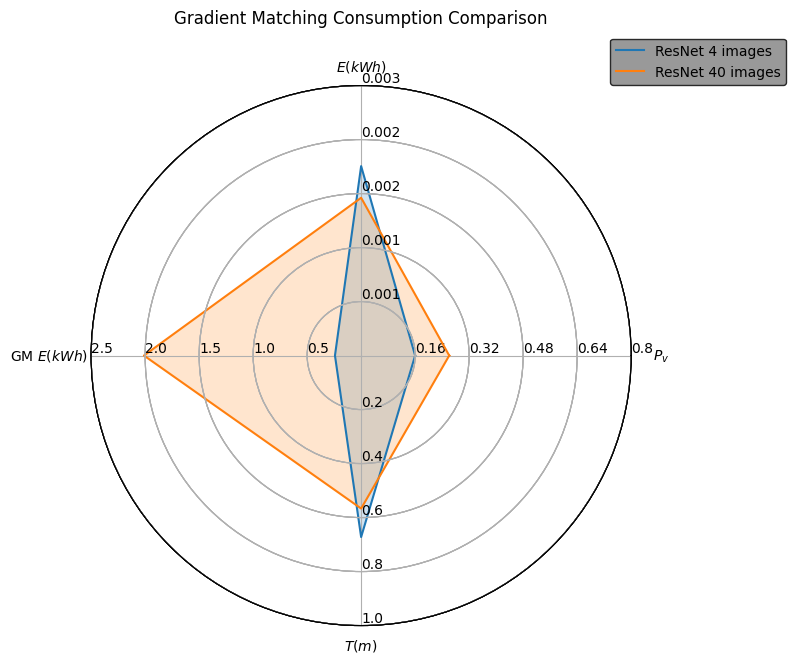

In [87]:
#[ResNet, DensNet, ConvNet]
GMacc_values_res= [0.16, 0.261]
# dm energy for generating 
GM_energy = [0.24228850000000002, 2.0108360000000003]


# Print the extracted values
print("Time values:", GMtime_res)
print("Energy values:", GMenergy_res)

GMlabels = ['ResNet 4 images', 'ResNet 40 images']
GMplot_radar3(GMlabels, GMacc_values_res, GMtime_res, GMenergy_res, GM_energy) #somelabel = something

# Full dataset


In [18]:
class ComplexRadar2():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,3)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        self.ax.legend
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def set_xlabel(self, label, labelpad=None):
        self.ax.set_xlabel(label, labelpad=labelpad)

In [19]:
#CONVNET
os.chdir(os.getcwd())
path1 = 'Data/Loss_Alzheimer_MRI/test/CarbonLogs/'
path2 = 'Data/Loss_Alzheimer_MRI/CarbonLogs/'
path3 = 'Data/Synthetic_Alzheimer_MRI/CarbonLogs/'
end = '.log'
full_conv = [f'{path1}Full1ConvNet_5124_2023-05-11T224746Z_carbontracker_output{end}'
                  ,f'{path1}Full1ConvNet_23740_2023-05-11T230056Z_carbontracker_output{end}'
                  ,f'{path1}Full1ConvNet_24000_2023-05-11T222950Z_carbontracker_output{end}'
                  ] 

full_dens = [f'{path2}128x128DenseNet_7784_2023-04-16T170034Z_carbontracker_output{end}'
                  ,f'{path2}128x128DenseNet_8732_2023-04-16T180216Z_carbontracker_output{end}'
                  ,f'{path2}128x128DenseNet_14012_2023-04-16T172540Z_carbontracker_output{end}'
                  ] 

full_res = [f'{path3}128x128FullResNet_208283_2023-04-16T153451Z_carbontracker_output{end}'
                  ,f'{path3}128x128FullResNet_220035_2023-04-16T154252Z_carbontracker_output{end}'
                  ,f'{path3}128x128FullResNet_231004_2023-04-16T155009Z_carbontracker_output{end}'
                  ] 


time_full_res, energy_values_res = process_log_files(full_res)
time_full_dens, energy_values_dens = process_log_files(full_dens)
time_full_conv, energy_values_conv = process_log_files(full_conv)


time_res = Average(time_full_res)
energy_res = Average(energy_values_res)
time_dens = Average(time_full_dens)
energy_dens = Average(energy_values_dens)
time_conv = Average(time_full_conv)
energy_conv = Average(energy_values_conv)


#FINAL
full_time = [time_res, time_dens, time_conv]
full_energy= [energy_res, energy_dens, energy_conv]


In [20]:
def Full_plot_radar(labels, acc_values, time_values, energy_values, total_energy, somelabel = 'RadarFull'):
    variables = (r'     $P_v$', r'$E(kWh)$', r'GM $E(kWh)$           ', r'$T(m)$')
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar2(fig1, variables, [(0, 1), (0, 0.06), (0,1), (0, 25)])
    for i in range(len(time_values)):
        data = (acc_values[i], energy_values[i], total_energy[i], time_values[i])
        radar.plot(data, label=labels[i])
        radar.fill(data, alpha=0.2)
    le = radar.ax.legend(loc='upper right', frameon=1, bbox_to_anchor=(1.3, 1.1))
    frame = le.get_frame()
    frame.set_facecolor('grey')
    frame.set_edgecolor('black')

    plt.title('Gradient Matching Consumption Comparison', y=1.1)
    plt.savefig(f'{somelabel}.png', bbox_inches = 'tight', dpi = 256)
    plt.show()

Time values: [6.300000000000001, 22.57777777777778, 13.972222222222221]
Energy values: [0.018231333333333332, 0.05046166666666666, 0.040309333333333336]


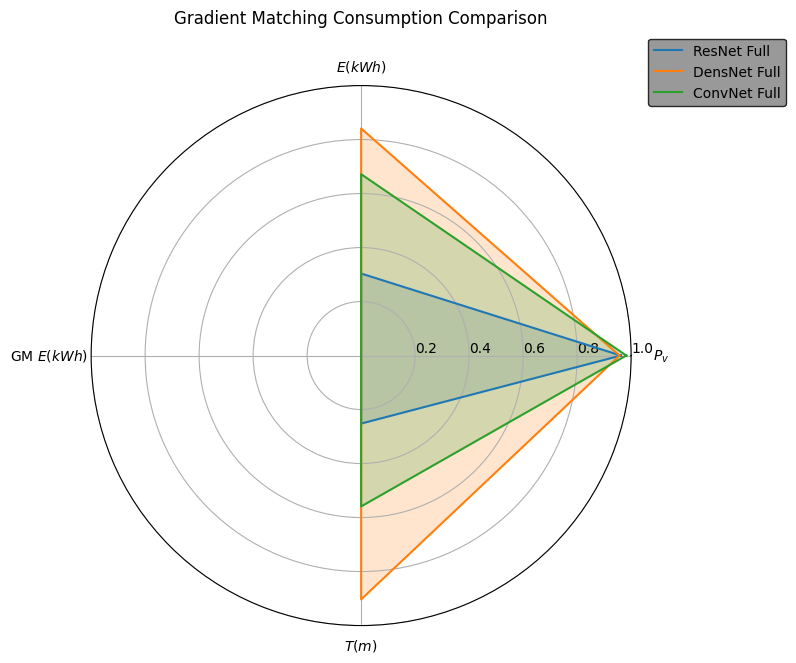

In [21]:
full_acc= [0.962, 0.957, 0.982]
# dm energy for generating 
full_energy_empty = [0, 0, 0]


# Print the extracted values
print("Time values:", full_time)
print("Energy values:", full_energy)

full_labels = ['ResNet Full', 'DensNet Full',  'ConvNet Full' ]
Full_plot_radar(full_labels, full_acc, full_time, full_energy, full_energy_empty) #somelabel = something